In [1]:
import sys
import time
import pickle as pkl

import numpy as np
import pandas as pd

import torch
import torch_geometric

import networkx as nx
from networkx import draw_networkx_nodes, draw_networkx_edges

from tqdm.notebook import tqdm

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep

%matplotlib inline
plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 20})

import awkward as ak
import fastjet
import vector

vector.register_awkward()

import xai4hep
from xai4hep.particlenet import ParticleNet
from xai4hep.particlenet.fastjet_utils import get_subjets

In [2]:
def get_eta_phi_pt(px, py, pz, e):
    """
    Computes the (eta, phi, pt) of the particles relative to the jet axis

    """

    # define jet directly not an array of jets
    jet = ak.zip(
        {
            "px": px,
            "py": py,
            "pz": pz,
            "E": e,
        },
        with_name="Momentum4D",
    )

    jet_vector = vector.obj(
        px=ak.sum(jet.px, axis=-1),
        py=ak.sum(jet.py, axis=-1),
        pz=ak.sum(jet.pz, axis=-1),
        E=ak.sum(jet.E, axis=-1),
    )

    deta = jet.deltaeta(jet_vector)
    dphi = jet.deltaphi(jet_vector)
    dpt = jet.pt / jet_vector.pt

    return deta, dphi, dpt

# Load Rscores

In [3]:
PATH = f"experiments/ParticleNet_model/xai/Rscores_best"

with open(f"{PATH}/batch_p4.pkl", "rb") as handle:
    batch_p4_list = pkl.load(handle)
with open(f"{PATH}/batch_y.pkl", "rb") as handle:
    batch_y_list = pkl.load(handle)
with open(f"{PATH}/R_edges.pkl", "rb") as handle:
    R_edges_list = pkl.load(handle)
with open(f"{PATH}/edge_index.pkl", "rb") as handle:
    edge_index_list = pkl.load(handle)

# Configuration

In [5]:
if torch.cuda.device_count():
    device = torch.device("cuda:0")
else:
    device = "cpu"

N_SUBJETS = 3

LABEL = {}
LABEL[fastjet.kt_algorithm] = "$k_{{\mathrm{{T}}}}$"
LABEL[fastjet.antikt_algorithm] = "anti-$k_{{\mathrm{{T}}}}$"
LABEL[fastjet.cambridge_algorithm] = "CA"

# JET_ALGO = fastjet.kt_algorithm
# JET_ALGO = fastjet.antikt_algorithm
JET_ALGO = fastjet.cambridge_algorithm

jetdef = fastjet.JetDefinition(JET_ALGO, 0.8)

# Make plots

In [6]:
def plot_jet(jet_index):
    # get the label of the jet
    jet_label = batch_y_list[jet_index]

    # get the p4
    px = batch_p4_list[jet_index][:, 0]
    py = batch_p4_list[jet_index][:, 1]
    pz = batch_p4_list[jet_index][:, 2]
    e = batch_p4_list[jet_index][:, 3]

    # define the edgeRscores and the edge_index of the last EdgeConv block
    edge_Rscores = R_edges_list[jet_index]["edge_conv_2"]
    edge_index = edge_index_list[jet_index]["edge_conv_2"]

    # get subjets
    subjet_idx, subjet_vectors = get_subjets(px, py, pz, e)
    print(f"# of particles in subjet 1: {(subjet_idx==0).sum()}")
    print(f"# of particles in subjet 2: {(subjet_idx==1).sum()}")
    print(f"# of particles in subjet 3: {(subjet_idx==2).sum()}")

    eta, phi, pt = get_eta_phi_pt(px, py, pz, e)
    eta = torch.tensor(eta).reshape(-1, 1)
    phi = torch.tensor(phi).reshape(-1, 1)
    eta_phi = torch.cat([eta, phi], axis=1)

    # Get positions of nodes in the graph
    pos = {}
    num_nodes = len(px)
    for node_i in range(num_nodes):
        pos[node_i] = eta_phi.numpy()[node_i]

    # subjet node colors
    COLOR_from_idx = ["Blues", "Reds", "Greens", "Oranges", "Yellows", "Purples"]

    Num_subjets = len(np.unique(subjet_idx))
    COLOR_from_idx = COLOR_from_idx[:Num_subjets]

    # plot nodes without connections
    fig, ax = plt.subplots(figsize=(12, 10))
    for j in range(Num_subjets):
        ax.scatter(
            eta[subjet_idx == j],
            phi[subjet_idx == j],
            c=pt[subjet_idx == j],
            cmap=COLOR_from_idx[j],
            norm=colors.LogNorm(vmin=0.001, vmax=0.1),
            label=f"{LABEL[JET_ALGO]} Subjet {j+1} $p_{{\mathrm{{T}}}}$={subjet_vectors[j].pt:.0f}",
        )

    plt.scatter([], [], c=[], cmap="Greys", norm=colors.LogNorm(vmin=0.001, vmax=0.1))
    cbar = plt.colorbar()
    cbar.set_label("$p_{\mathrm{T}} / p_{\mathrm{T}}^{\mathrm{jet}}$")
    ax.legend(title="Top quark jet" if jet_label == 1 else "QCD jet", title_fontsize=40, fontsize=20)

    plt.xlabel(r"$\Delta\eta$", fontsize=30)
    plt.ylabel(r"$\Delta\phi$", fontsize=30)

    plt.ylim(-0.8, 0.8)
    plt.xlim(-0.8, 0.8)
    ax.set_xticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6])
    ax.set_yticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6])
    ax.tick_params(pad=10, left=True, bottom=True, labelleft=True, labelbottom=True)
    plt.show()

# of particles in subjet 1: 22
# of particles in subjet 2: 21
# of particles in subjet 3: 14


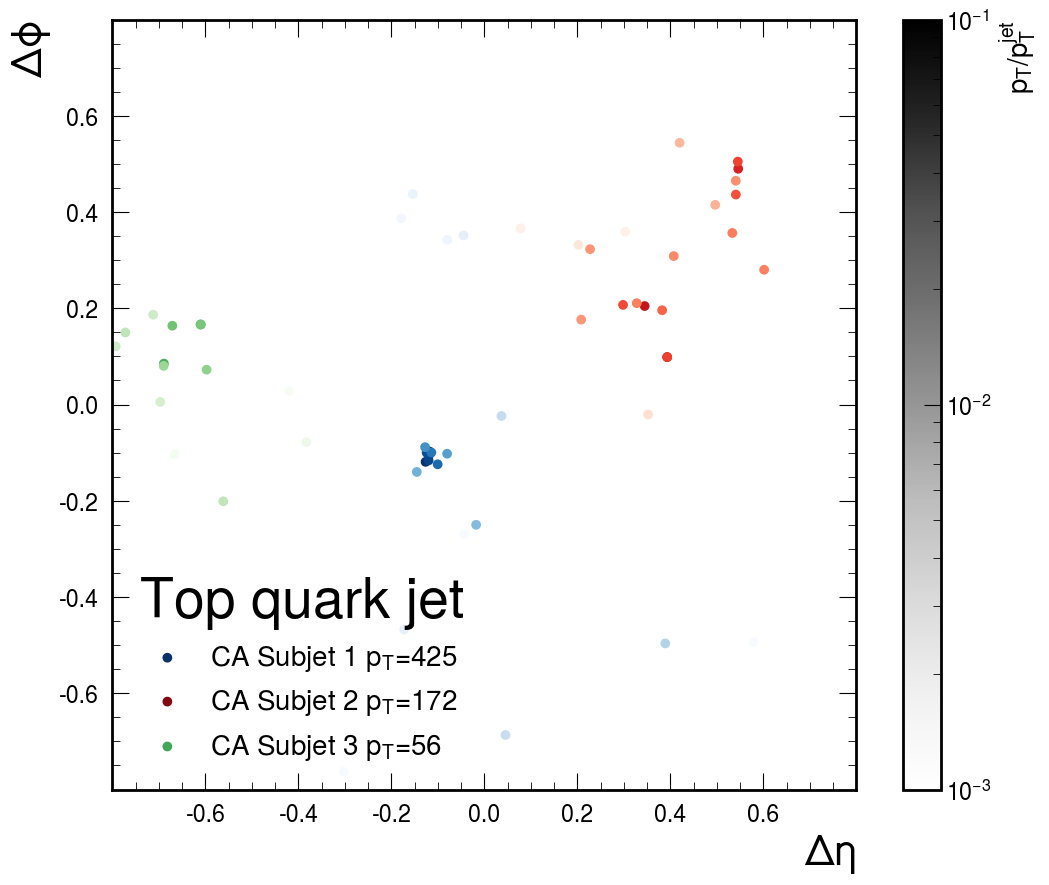

In [9]:
jet_index = 1 # top
# jet_index = 4 # QCD

plot_jet(jet_index)

# Include the edge R scores

In [10]:
def remove_edges_between_superimposed_nodes(G, eta_phi):
    def get_duplicate_indices(eta_phi):
        _, ind = np.unique(eta_phi, axis=0, return_index=True)
        ret = []
        for i in range(len(eta_phi)):
            if i not in ind:
                ret.append(i)
        return ret

    def get_edges_to_remove(ret):
        tuples_ = []
        for ind in ret:
            x = np.unique(np.where(eta_phi == eta_phi[ind])[0])
            tuples_.append((x[0], x[1]))
        return tuples_

    ind = get_duplicate_indices(eta_phi)
    tuples_ = get_edges_to_remove(ind)

    for edge in list(G.edges):
        if (edge in tuples_) or edge in [tuple(reversed(x)) for x in tuples_]:
            G.remove_edge(edge[0], edge[1])

    return G

In [11]:
def plot_edgeRgraph(jet_index, edgeconv):
    """
    edgeconv [int] and choices are [1,2,3] assuming the model was designed to have three EdgeConv blocks

    """

    label = {
        "edge_conv_0": "1st EdgeConv",
        "edge_conv_1": "2nd EdgeConv",
        "edge_conv_2": "3rd EdgeConv",
    }

    i = jet_index

    # get the label of the jet
    jet_label = batch_y_list[jet_index]

    # get the p4
    px = batch_p4_list[jet_index][:, 0]
    py = batch_p4_list[jet_index][:, 1]
    pz = batch_p4_list[jet_index][:, 2]
    e = batch_p4_list[jet_index][:, 3]

    # get subjets
    subjet_idx, subjet_vectors = get_subjets(px, py, pz, e)
    print(f"# of particles in subjet 1: {(subjet_idx==0).sum()}")
    print(f"# of particles in subjet 2: {(subjet_idx==1).sum()}")
    print(f"# of particles in subjet 3: {(subjet_idx==2).sum()}")

    eta, phi, pt = get_eta_phi_pt(px, py, pz, e)
    eta = torch.tensor(eta).reshape(-1, 1)
    phi = torch.tensor(phi).reshape(-1, 1)
    eta_phi = torch.cat([eta, phi], axis=1)

    # Get positions of nodes in the graph
    pos = {}
    num_nodes = len(px)
    for node_i in range(num_nodes):
        pos[node_i] = eta_phi.numpy()[node_i]

    # subjet node colors
    COLOR_from_idx = ["Blues", "Reds", "Greens", "Oranges", "Yellows", "Purples"]

    Num_subjets = len(np.unique(subjet_idx))
    COLOR_from_idx = COLOR_from_idx[:Num_subjets]

    # plot the edgeconv block specefied
    edgeconv = f"edge_conv_{edgeconv-1}"
    edge_Rscores = R_edges_list[jet_index][edgeconv]
    edge_index = edge_index_list[jet_index][edgeconv]

    data = torch_geometric.data.Data(edge_index=edge_index, edge_weight=edge_Rscores, num_nodes=num_nodes)
    G = torch_geometric.utils.to_networkx(data, to_undirected=False)

    print(f"Plotting the Edge-Rgraph for edge_conv_{edgeconv}...")
    fig, ax = plt.subplots(figsize=(12, 10))
    for j in range(Num_subjets):
        draw_networkx_nodes(
            G,
            pos,
            nodelist=np.array(list(G))[subjet_idx == j].tolist(),
            node_color=np.log(pt[subjet_idx == j]),
            node_size=100,
            cmap=COLOR_from_idx[j],
            ax=ax,
            label=f"{LABEL[JET_ALGO]} Subjet {j} $p_{{\mathrm{{T}}}}$={subjet_vectors[j].pt:.0f}",
        )
    plt.scatter([], [], c=[], cmap="Greys", norm=colors.LogNorm(vmin=0.001, vmax=0.1))
    cbar = plt.colorbar()
    cbar.set_label("$p_{\mathrm{T}} / p_{\mathrm{T}}^{\mathrm{jet}}$")

    draw_networkx_edges(
        G, pos, width=100 * (edge_Rscores), edge_color="k", style="solid", arrowsize=10, ax=ax, arrowstyle="-"
    )

    ax.legend(title="Top quark jet" if jet_label == 1 else "QCD jet", title_fontsize=40, fontsize=20)
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

    plt.xlabel(r"$\Delta\eta$", fontsize=30)
    plt.ylabel(r"$\Delta\phi$", fontsize=30)

    plt.ylim(-0.8, 0.8)
    plt.xlim(-0.8, 0.8)
    ax.set_xticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6])
    ax.set_yticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6])
    ax.set_title(f"{label[edgeconv]}", pad=10, fontsize=35)
    plt.show()

# of particles in subjet 1: 22
# of particles in subjet 2: 21
# of particles in subjet 3: 14
Plotting the Edge-Rgraph for edge_conv_edge_conv_0...


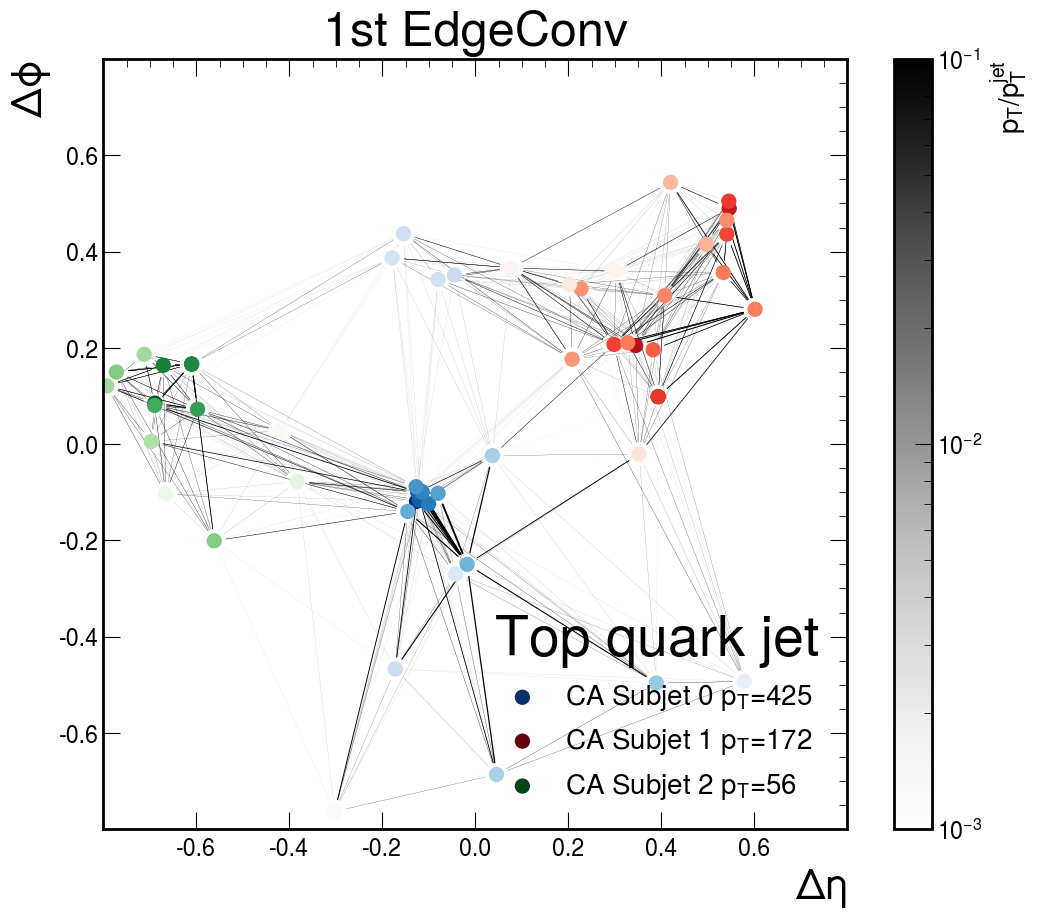

In [12]:
plot_edgeRgraph(jet_index, edgeconv=1)

# of particles in subjet 1: 22
# of particles in subjet 2: 21
# of particles in subjet 3: 14
Plotting the Edge-Rgraph for edge_conv_edge_conv_1...


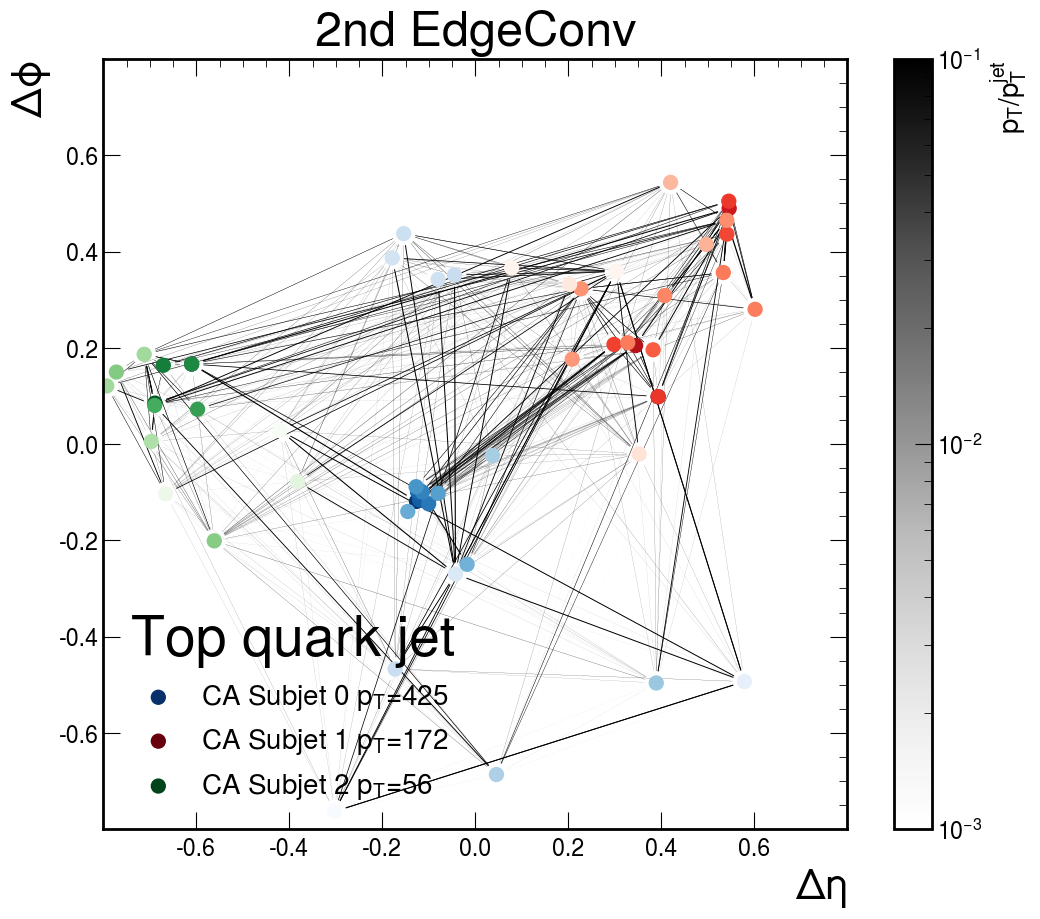

In [13]:
plot_edgeRgraph(jet_index, edgeconv=2)

# of particles in subjet 1: 22
# of particles in subjet 2: 21
# of particles in subjet 3: 14
Plotting the Edge-Rgraph for edge_conv_edge_conv_2...


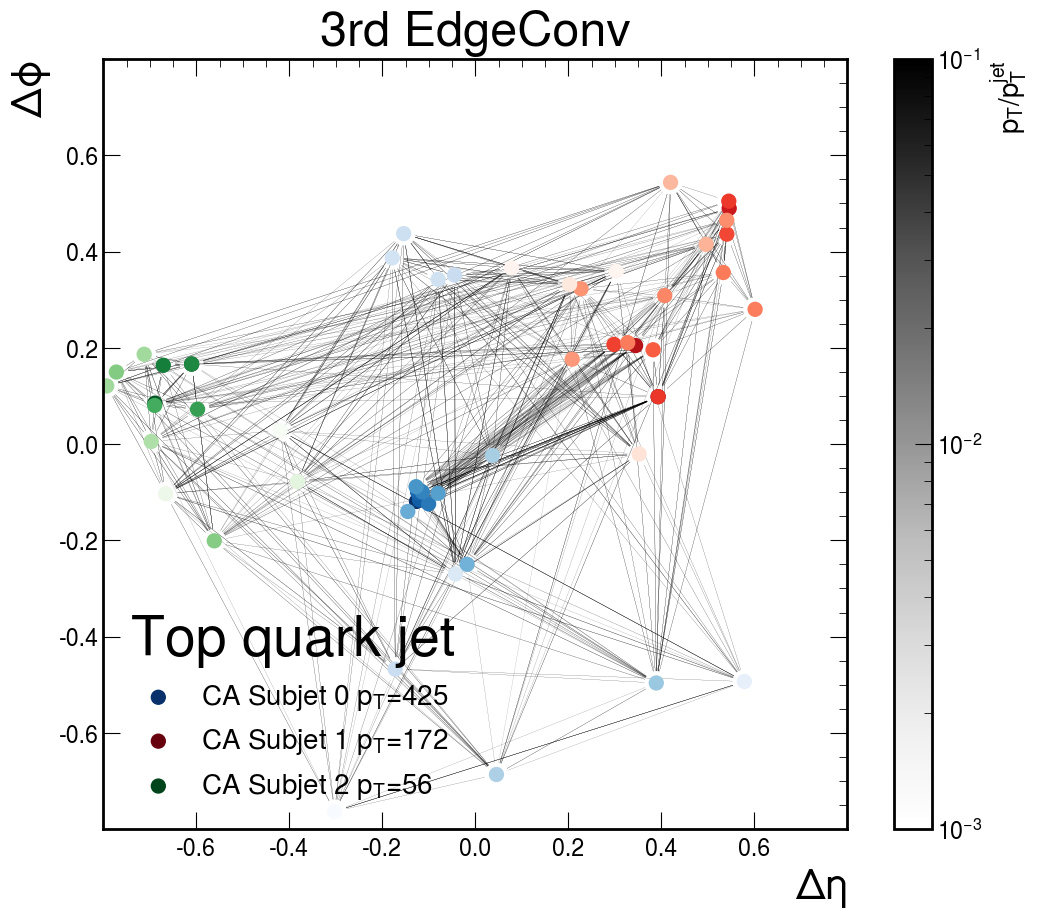

In [14]:
plot_edgeRgraph(jet_index, edgeconv=3)